<a href="https://colab.research.google.com/github/ChintPatel/CMPE258-HW6/blob/main/Part1_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 Setup: Install Required Libraries
!pip install -q keras-tuner keras-cv fastai nlpaug

In [2]:
import tensorflow as tf
import keras_cv
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import os, datetime
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [3]:
# ⚡ Load and Preprocess Fashion MNIST (smaller, faster)
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, y_train = x_train[:5000] / 255.0, y_train[:5000]
x_test, y_test = x_test[:1000] / 255.0, y_test[:1000]
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# 🔧 Hyperparams
EPOCHS = 5
BATCH_SIZE = 256

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
import uuid # Import the uuid module

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.8270000219345093

Best val_accuracy So Far: 0.8420000076293945
Total elapsed time: 00h 00m 37s
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3419 - loss: 1.8677 - val_accuracy: 0.7150 - val_loss: 0.8663
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6853 - loss: 0.9095 - val_accuracy: 0.7800 - val_loss: 0.6436
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7521 - loss: 0.7278 - val_accuracy: 0.8010 - val_loss: 0.5692
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7701 - loss: 0.6655 - val_accuracy: 0.8250 - val_loss: 0.5365
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7990 - loss: 0.6016 - val_accuracy: 0.8440 - val_loss: 0.4972


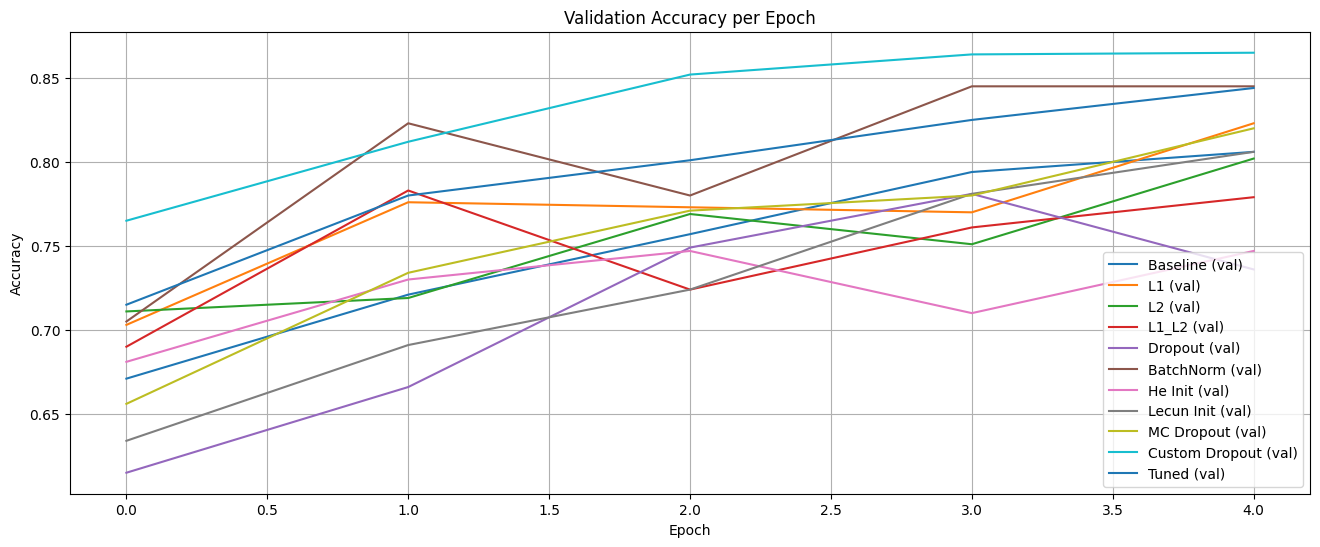

In [7]:
# 🧱 Model Factory

def build_model(regularizer=None, dropout_rate=0.0, initializer='glorot_uniform'):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', kernel_initializer=initializer,
                      kernel_regularizer=regularizer, input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_initializer=initializer,
                     kernel_regularizer=regularizer),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=1.0),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ✅ Regularization Techniques
log_dir = os.path.join("logs", str(uuid.uuid4()))
tensorboard_cb = TensorBoard(log_dir=log_dir)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=2)

models = {
    "Baseline": build_model(),
    "L1": build_model(regularizer=regularizers.l1(0.001)),
    "L2": build_model(regularizer=regularizers.l2(0.001)),
    "L1_L2": build_model(regularizer=regularizers.l1_l2(1e-4, 1e-4)),
    "Dropout": build_model(dropout_rate=0.5),
    "BatchNorm": build_model(),
    "He Init": build_model(initializer='he_normal'),
    "Lecun Init": build_model(initializer='lecun_normal')
}

histories = {}
for name, model in models.items():
    try:
        print(f"Training: {name}")
        history = model.fit(x_train, y_train, validation_split=0.2,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            callbacks=[early_stop_cb], verbose=1)
        histories[name] = history
    except Exception as e:
        print(f"❌ Failed on {name}: {e}")

# 🧪 Monte Carlo Dropout
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

def mc_model():
    model = keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
        MCDropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        MCDropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mc = mc_model()
histories["MC Dropout"] = mc.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# 🧪 Custom Dropout Layer
class CustomDropout(layers.Layer):
    def __init__(self, rate):
        super().__init__()
        self.rate = rate
    def call(self, inputs, training=None):
        return tf.nn.dropout(inputs, rate=self.rate) if training else inputs

def custom_dropout_model():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = CustomDropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = CustomDropout(0.3)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cd_model = custom_dropout_model()
histories["Custom Dropout"] = cd_model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# 🧪 Keras Tuner

def model_builder(hp):
    hp_units = hp.Int('units', 32, 128, step=32)
    hp_dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)
    model = keras.Sequential([
        layers.Flatten(input_shape=(28,28,1)),
        layers.Dense(hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=EPOCHS, directory='kt_dir', project_name='fm_tune')
tuner.search(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop_cb], verbose=1)
best_hp = tuner.get_best_hyperparameters(1)[0]
tuned_model = tuner.hypermodel.build(best_hp)
histories['Tuned'] = tuned_model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# 📊 Plot Results

def plot_history(histories):
    plt.figure(figsize=(16,6))
    for name, hist in histories.items():
        plt.plot(hist.history['val_accuracy'], label=f'{name} (val)')
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(histories)